In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pickle

# 1. Import Data

In [2]:
data = pd.read_csv("/home/akanksha/Akanksha/Assignments/securly_Classification/dataset/train.csv")
data.shape

(159571, 8)

In [3]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
data.drop(columns=['id'], inplace=True)

## 2. Visualization

### 2.1. Check missing values

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 8.5+ MB


In [6]:
data.isna().sum()

comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

### 2.2. Number of comments for each toxic word

In [7]:
toxic_words = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

data[toxic_words].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

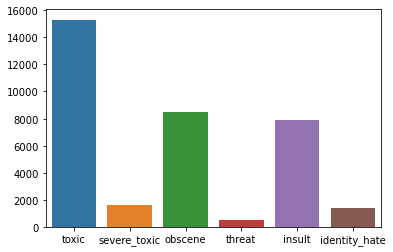

In [8]:
sb.barplot(toxic_words, data[toxic_words].sum().values)

### 2.3. Comments with multiple toxic words

In [9]:
sum_of_toxic_words_for_each_comment = data[toxic_words].sum(axis=1)
count_of_comments_for_each_toxic_word = sum_of_toxic_words_for_each_comment.value_counts()[1:]
count_of_comments_for_each_toxic_word

1    6360
3    4209
2    3480
4    1760
5     385
6      31
dtype: int64

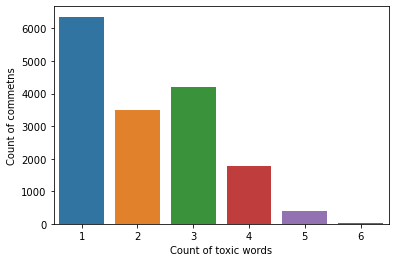

In [10]:
plt.xlabel("Count of toxic words")
plt.ylabel("Count of commetns")

sb.barplot(count_of_comments_for_each_toxic_word.index, count_of_comments_for_each_toxic_word.values)

### 2.4. Number of comments with and without toxic words

In [11]:
comments_with_toxic_words = sum_of_toxic_words_for_each_comment != 0
comments_without_toxic_words = sum_of_toxic_words_for_each_comment == 0
print('Number of comments with toxic words = {} \nNumber of commets without toxic words = {}'
      .format(comments_with_toxic_words.sum(), comments_without_toxic_words.sum()))

Number of comments with toxic words = 16225 
Number of commets without toxic words = 143346


## 3. Data Preprocessing

In [12]:
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer

porter = PorterStemmer()

stop_words = stopwords.words('english')

stop_words.append("hi")
stop_words.append("u")

TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z]+"


# Function to remove unwanted data and stop words. 
# Also it tokenizes the data to converts the words in it's stem form.
def preprocess(text):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip().split()
    tokens = [porter.stem(token) for token in text if token not in stop_words]
    return " ".join(tokens)

In [13]:
%%time
import sys
sys.setrecursionlimit(10000)

data['text'] = data.comment_text.apply(lambda x: preprocess(x))

CPU times: user 1min 46s, sys: 121 ms, total: 1min 46s
Wall time: 1min 46s


## 4. Word Cloud Represntaion

The following figure shows most common words in each category 

Toxic


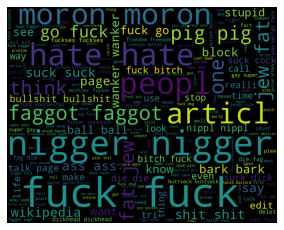

Severe_toxic


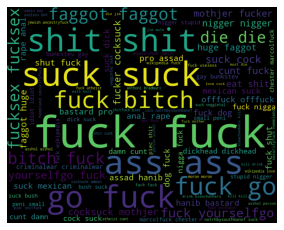

Obscene


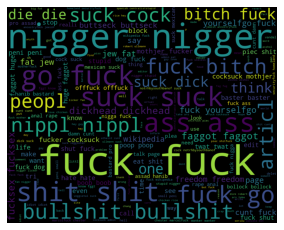

Threat


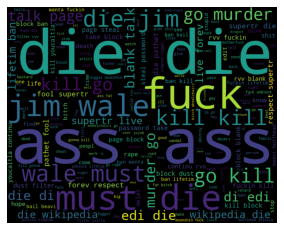

Insult


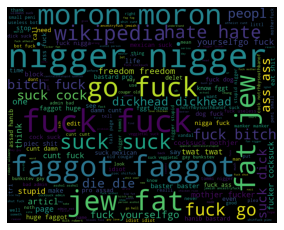

Identity_hate


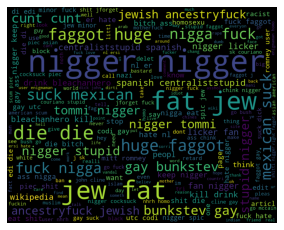

In [14]:
from wordcloud import WordCloud,STOPWORDS

def print_wordCloud(df):
    comment_words = '' 
    stopwords = set(STOPWORDS) 
    

    # iterate through the csv file 
    for val in df.text: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        comment_words += " ".join(tokens)+" "
                
    wordcloud = WordCloud(width = 1000, height = 800, 
            background_color ='black', 
            stopwords = stopwords, 
            min_font_size = 10).generate(comment_words) 
#     plot the WordCloud image                        
    plt.figure(figsize = (5, 3), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 

for i in toxic_words:
    print('\033[1m' + i.capitalize())
    print_wordCloud(data[data[i] == 1])

## 4. Split data into Train and Test set

In [15]:
from sklearn.model_selection import train_test_split

feature = data['text'] 
label = data.drop(columns=['comment_text', 'text'])

X_train, X_test, y_train, y_test = train_test_split(feature,
                                                    label,
                                                    test_size=0.2,
                                                    train_size=0.8,
                                                    random_state=42)

In [16]:
from collections import Counter
word_counts = dict()
top_phrases = dict()

for kind in y_train.columns:
    word_counts[kind] = Counter()
    comments = X_train[y_train[kind]==1]
    for _, comment in comments.iteritems():
        word_counts[kind].update(comment.split(" "))

def most_common_words(kind, num_words=15):
    words, counts = zip(*word_counts[kind].most_common(num_words)[::-1])
    plt.bar(words,counts)
    plt.xticks(rotation=45) 
    plt.plot()
    return list(words)

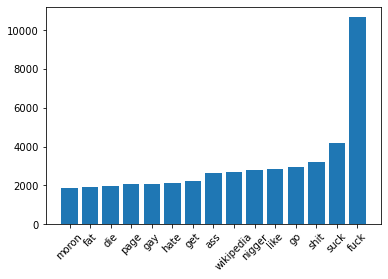

In [17]:
top_phrases["toxic"] = most_common_words("toxic")

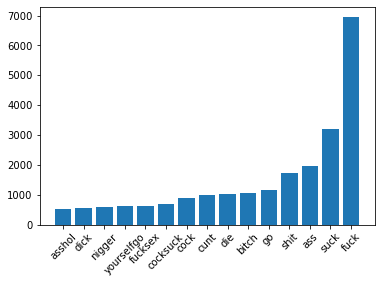

In [18]:
top_phrases["severe_toxic"] = most_common_words("severe_toxic")

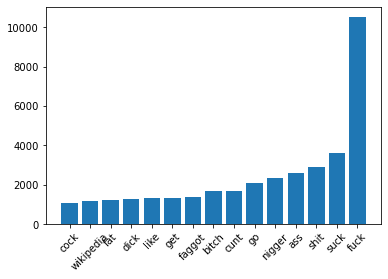

In [19]:
top_phrases["obscene"] =  most_common_words('obscene')

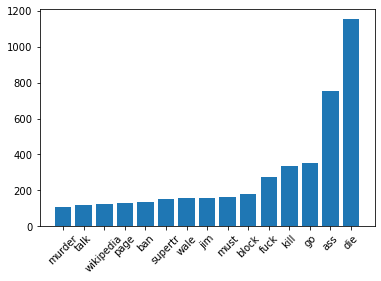

In [20]:
top_phrases["threat"] = most_common_words('threat')

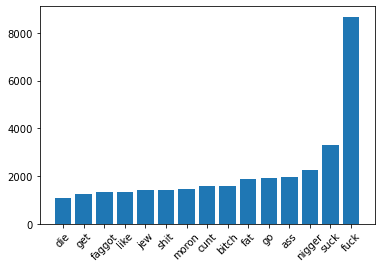

In [21]:
top_phrases["insult"] = most_common_words('insult')

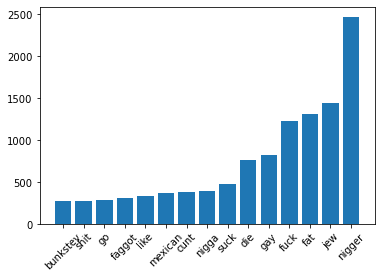

In [22]:
top_phrases["identity_hate"] = most_common_words('identity_hate')

In [23]:
obj = dict()
obj['top_phrases'] = top_phrases

## 5. TF-IDF

It converts words to numbers. He we are using TDIDF as it assigns score to each words, and count vectoriser counts occurances of each word.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(X_train)
vectorizer.fit(X_test)

TfidfVectorizer(ngram_range=(1, 3), strip_accents='unicode')

In [25]:
X_train_vec = vectorizer.transform(X_train)

X_test_vec = vectorizer.transform(X_test)

In [26]:
obj['vectorizer'] = vectorizer
pickle.dump(obj, open("vectorizer.pickle", 'wb'))

## 6. Train the model

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
import sklearn

### Logistic Regression

In [28]:
%%time
Logistic_Regression_Pipeline = Pipeline([
                ('clf', OneVsRestClassifier(
                    sklearn.linear_model.LogisticRegression(solver='sag'), 
                    n_jobs=-1)),
            ])

for category in toxic_words:
    print("\033[1m" + "Accuracy for " + category.capitalize() +  "\033[0m")

    Logistic_Regression_Pipeline.fit(X_train_vec, y_train[category])
    
    test_prediction = Logistic_Regression_Pipeline.predict(X_test_vec)
    train_prediction = Logistic_Regression_Pipeline.predict(X_train_vec)
    print("Train Accuracy is {}".format(sklearn.metrics.accuracy_score(y_train[category], train_prediction)))
    print('Test accuracy is {}'.format(sklearn.metrics.accuracy_score(y_test[category], test_prediction)))
    print("Hamming Loss is {} \n ".format(sklearn.metrics.hamming_loss(y_test[category], test_prediction))) 
    
    obj = dict()
    obj[category] = Logistic_Regression_Pipeline
    pickle.dump(obj, open('Logistic_Regression/' + category + ".pickle", 'wb'))

Accuracy for Toxic
Train Accuracy is 0.9615607570345303
Test accuracy is 0.9385555381482061
Hamming Loss is 0.06144446185179383 
 
Accuracy for Severe_toxic
Train Accuracy is 0.9908817446888513
Test accuracy is 0.9900046999843334
Hamming Loss is 0.009995300015666614 
 
Accuracy for Obscene
Train Accuracy is 0.9794682584445698
Test accuracy is 0.964844117186276
Hamming Loss is 0.035155882813723956 
 
Accuracy for Threat
Train Accuracy is 0.9969997493263145
Test accuracy is 0.9976500078333073
Hamming Loss is 0.0023499921666927776 
 
Accuracy for Insult
Train Accuracy is 0.9736400952560005
Test accuracy is 0.9587028043239856
Hamming Loss is 0.04129719567601441 
 
Accuracy for Identity_hate
Train Accuracy is 0.9924249545653945
Test accuracy is 0.9907880307065643
Hamming Loss is 0.00921196929343569 
 
CPU times: user 959 ms, sys: 501 ms, total: 1.46 s
Wall time: 49.3 s


### SVM

In [29]:
%%time
SVM_Pipeline = Pipeline([
                ('clf', OneVsRestClassifier(
                    sklearn.svm.LinearSVC(C=0.1), 
                    n_jobs=-1)),
            ])

for category in toxic_words:
    print("\033[1m" + "Accuracy for " + category.capitalize() +  "\033[0m")
    
    SVM_Pipeline.fit(X_train_vec, y_train[category])
    
    test_prediction = SVM_Pipeline.predict(X_test_vec)
    train_prediction = SVM_Pipeline.predict(X_train_vec)
    print("Train Accuracy is {}".format(sklearn.metrics.accuracy_score(y_train[category], train_prediction)))
    print('Test accuracy is {} '.format(sklearn.metrics.accuracy_score(y_test[category], test_prediction)))
    print("Hamming Loss is {} \n ".format(sklearn.metrics.hamming_loss(y_test[category], test_prediction))) 
    
    obj = dict()
    obj[category] = SVM_Pipeline
    pickle.dump(obj, open('SVM/' + category + ".pickle", 'wb'))

Accuracy for Toxic
Train Accuracy is 0.9629864636209814
Test accuracy is 0.9398402005326649 
Hamming Loss is 0.06015979946733511 
 
Accuracy for Severe_toxic
Train Accuracy is 0.9909287460048881
Test accuracy is 0.9900046999843334 
Hamming Loss is 0.009995300015666614 
 
Accuracy for Obscene
Train Accuracy is 0.9811133045058595
Test accuracy is 0.9670374432085226 
Hamming Loss is 0.03296255679147736 
 
Accuracy for Threat
Train Accuracy is 0.9969605815629504
Test accuracy is 0.9976500078333073 
Hamming Loss is 0.0023499921666927776 
 
Accuracy for Insult
Train Accuracy is 0.9749796327630507
Test accuracy is 0.9597368008773304 
Hamming Loss is 0.04026319912266959 
 
Accuracy for Identity_hate
Train Accuracy is 0.9923701196966849
Test accuracy is 0.9908506971643428 
Hamming Loss is 0.009149302835657215 
 
CPU times: user 890 ms, sys: 261 ms, total: 1.15 s
Wall time: 7.62 s


In [30]:
%%time
lr = sklearn.linear_model.LogisticRegression()
clf = OneVsRestClassifier(lr)

# fit model on train data
clf.fit(X_train_vec, y_train)

# make predictions for validation set
y_pred = clf.predict(X_test_vec)
sklearn.metrics.accuracy_score(y_test, y_pred)

CPU times: user 11min 21s, sys: 3min 56s, total: 15min 18s
Wall time: 3min


0.9068776437411875

In [31]:
%%time
svm = sklearn.svm.LinearSVC(C=0.1)
clf = OneVsRestClassifier(svm)

# fit model on train data
clf.fit(X_train_vec, y_train)

# make predictions for validation set
y_pred = clf.predict(X_test_vec)
sklearn.metrics.accuracy_score(y_test, y_pred)

CPU times: user 4.81 s, sys: 188 ms, total: 5 s
Wall time: 5 s


0.9078803070656432